In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import anuga
%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

/tmp/ipykernel_1735/3585637201.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Cargado de datos

In [2]:
''' PARÁMETROS '''

# ARCHIVOS
# INPUT_FOLDER = "C:/Users/JorgeOvalle/Desktop/Proyecto Relaves/data_descargas/input"
INPUT_FOLDER = os.path.abspath("input")
CICLO = 9
SECTORES = [5, 6]

# PARÁMETROS DE SIMULACIÓN
MANNING = 0.025
G = 2.7
C_p = 0.499
    

folder_ciclo = os.path.join(INPUT_FOLDER, f"ciclo_{CICLO}")

In [3]:
# DESCARGAS

suffix_input = '_'.join([str(s) for s in SECTORES])
df_descargas = pd.read_csv(os.path.join(folder_ciclo, "input_sectores_{}.csv".format(suffix_input)), parse_dates=['fecha'])

In [4]:
# POLIGONOS
poligono_sector_5 = anuga.read_polygon(os.path.join(folder_ciclo,'poligono_sector_5_extendido.csv'))
poligono_sector_6 = anuga.read_polygon(os.path.join(folder_ciclo,'poligono_sector_6.csv'))
zona_interior_sector_5 = anuga.read_polygon(os.path.join(folder_ciclo,'zona_interior_sector_5.csv'))
zona_interior_sector_6 = anuga.read_polygon(os.path.join(folder_ciclo,'zona_interior_sector_6.csv'))

# ARCHIVO TOPO
archivo_topo = os.path.join(folder_ciclo, "DEM_04.02.2023_10x10m.asc")

# RESOLUCIONES
poligono_res = 100
zona_interior_res = 50

# REGIONES_INTERIORES
region_interior_sector_5 = [[zona_interior_sector_5, zona_interior_res]]
region_interior_sector_6 = [[zona_interior_sector_6, zona_interior_res]]

In [34]:
poligono_sector_5

[[486787.3739383626, 7294205.855877196],
 [488241.5855731228, 7294401.760035247],
 [489678.2160654936, 7297469.250783524],
 [486205.5218450076, 7302375.74995564]]

# Creación de dominio para descargas del sector 5

In [24]:
domain = anuga.create_domain_from_regions(poligono_sector_5, 
                                          boundary_tags={'l1': [0], 'l2': [1], 'l3': [2], 'l4': [3]}, 
                                          maximum_triangle_area=poligono_res,
                                          interior_regions=region_interior_sector_5,
                                          mesh_filename='malla_sector_5.msh')
domain.set_time(500)
domain.set_name('relaves_sector_5') # Nombre del archivo de salida
dplotter = anuga.Domain_plotter(domain, plot_dir='figuras_test') # Carpeta de salida de las figuras

Figure files for each frame will be stored in figuras_test


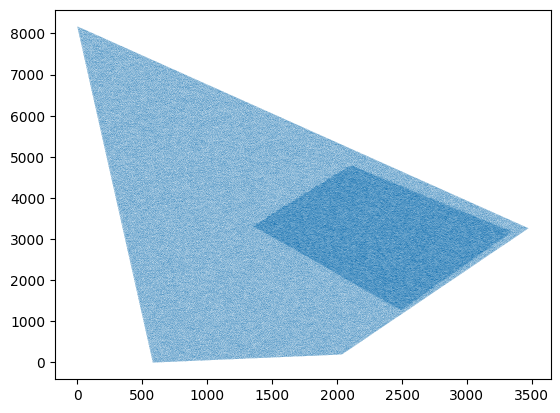

In [14]:
# Graficamos
plt.triplot(dplotter.triang, linewidth = 0.07)

# Condiciones iniciales

In [25]:
domain.set_quantity('elevation', filename=archivo_topo, location='centroids') # Use function for elevation
domain.set_quantity('friction', MANNING, location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids')

Text(0.5, 1.0, 'Elevation')

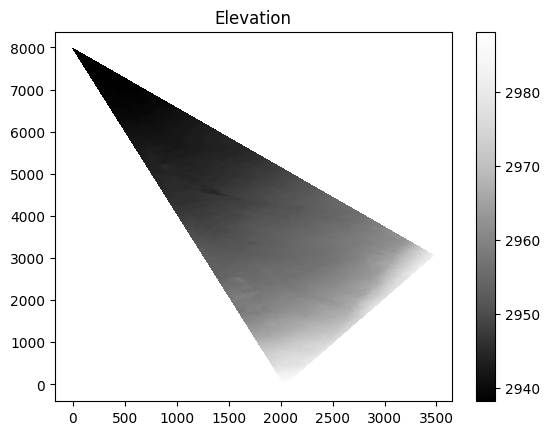

In [9]:
plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar()
plt.title("Elevation")

In [26]:
Bt = anuga.Transmissive_boundary(domain)
domain.set_boundary({'l1': Bt, 'l2': Bt, 'l3': Bt, 'l4': Bt})

In [35]:
poligono_sector_5

[[486787.3739383626, 7294205.855877196],
 [488241.5855731228, 7294401.760035247],
 [489678.2160654936, 7297469.250783524],
 [486205.5218450076, 7302375.74995564]]

In [42]:
# ejemplo de dataframe
df = pd.DataFrame({'x': [0, 1, 2, 3, 4], 'y': [1, 2, 3, 4, 5], 'z': [2, 3, 4, 5, 6], 'w': [3, 4, 5, 6, 7]})

In [43]:
df.set_index(['x', 'y'], inplace=True)

In [48]:
list(df.loc[(0, 1)].values)

[2, 3]

In [51]:
~np.all([True, True])


False

In [55]:
dic = {'a': 1, 'b': 2, 'c': 3}
list(dic.values())

[1, 2, 3]

# Operadores Inlet

In [27]:
def calcular_caudal(tasa_masa_seca: float):
    q = tasa_masa_seca * (C_p + G * (1 - C_p)) / (C_p * G)
    return q

def calcular_velocidad_inicial(tasa_masa_seca: float, radio_canaleta: float, angulo_polar: float):
    q = calcular_caudal(tasa_masa_seca)
    rapidez = 2*q / (np.pi * radio_canaleta**2)
    return rapidez * np.array([np.sin(angulo_polar), np.cos(angulo_polar)])

In [10]:
# Descarga sector 5 día 1
df_descargas_sector_5 = df_descargas[df_descargas.sector == 5]
df_descargas_sector_5 = df_descargas_sector_5[df_descargas_sector_5.fecha == df_descargas_sector_5.fecha.min()]

In [93]:
df_descargas_sector_5

,fecha,sector,id_punto,coordenada_x,coordenada_y,angulo_polar,tms,tasa_diaria,radio_canaleta
153,2023-03-02,5,29,489215.492474,7.297292e+06,2.425051,22137.258627,0.961598,1.6345
154,2023-03-02,5,32,489082.721325,7.296706e+06,2.536601,22137.258627,0.961598,1.4370
155,2023-03-02,5,33,488926.557163,7.296312e+06,2.907850,22137.258627,0.961598,1.6430
156,2023-03-02,5,37,488770.083732,7.295805e+06,2.377836,44274.517254,1.923196,1.3145


In [28]:
# Creamos las distintas regiones para establecer canaletas de salida
operadores_inlet = []

for index, row in df_descargas_sector_5.iterrows():
    center = (row.coordenada_x, row.coordenada_y)
    radius = row.radio_canaleta

    while True:
        try:
            region = anuga.Region(domain, center=center, radius=radius)
            break
        except:
            radius += 1
            print("Error, aumentando radio")

    canaleta = anuga.Inlet_operator(domain, region=region, 
                                    Q=calcular_caudal(row.tasa_diaria),
                                    velocity=calcular_velocidad_inicial(row.tasa_diaria, row.radio_canaleta, row.angulo_polar))
    operadores_inlet.append(canaleta)


Error, aumentando radio
Error, aumentando radio
Error, aumentando radio
Error, aumentando radio
Error, aumentando radio


In [71]:
domain.centroid_coordinates[domain.get_wet_elements()]

# Obtenemos las coordenadas de los centroides que tienen agua
centroids = domain.centroid_coordinates
wet_indices = domain.get_wet_elements()
wet_centroids = centroids[wet_indices]

# Calculamos la distancia mínima del volumen de agua a cada borde
distancias = {}
planos_bordes = {0: (4, 2, 1)}
for idx, plano in planos_bordes.items():
    a, b, c = plano
    distancias[idx] = np.abs(a * wet_centroids[:, 0] + b * wet_centroids[:, 1] + c) / np.sqrt(a**2 + b**2)
    # distancias[idx] = distancias[idx].min()

In [72]:
domain.set_boundary()

array([], dtype=float64)

In [44]:
region.areas[region.get_indices()].sum()

29.559254290768877

In [45]:
df_descargas_sector_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 153 to 156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha           4 non-null      datetime64[ns]
 1   sector          4 non-null      int64         
 2   id_punto        4 non-null      int64         
 3   coordenada_x    4 non-null      float64       
 4   coordenada_y    4 non-null      float64       
 5   angulo_polar    4 non-null      float64       
 6   tms             4 non-null      float64       
 7   tasa_diaria     4 non-null      float64       
 8   radio_canaleta  4 non-null      float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 320.0 bytes


In [50]:
canaleta = operadores_inlet[0]

In [52]:
canaleta.get_Q()

1.3215996014679452

In [53]:
calcular_caudal(df_descargas_sector_5.tasa_diaria.iloc[0])

1.3215996014679452

In [29]:
t_inlet_max = 12000

In [33]:
domain.get_time()

1500.0

In [32]:
inlets_activados = True
for t in domain.evolve(yieldstep=400, duration=1000, skip_initial_step=True):
    print(t)
  
    #dplotter.plot_depth_frame()
    dplotter.save_depth_frame()
    
    if inlets_activados and t >= t_inlet_max:
        for op in operadores_inlet:
            op.set_Q(0)
        inlets_activados = False
    
    domain.print_timestepping_statistics()


900.0
Time = 900.0000 (sec), delta t = 1000.00000000 (s), steps=1 (358s)
1300.0
Time = 1300.0000 (sec), delta t in [0.07178085, 0.45539220] (s), steps=1009 (89s)
1500.0
Time = 1500.0000 (sec), delta t in [0.36994838, 0.41913881] (s), steps=488 (45s)


In [16]:
domain.get_time()

500

In [55]:
np.min(domain.centroid_coordinates, axis=0).min()

3.169637806915793

In [85]:
dplotter.make_depth_animation() 